### Setting the Font to look nice for latex

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
font_path = '/Library/Fonts/latinmodern-math.otf' 
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Latin Modern Math'

# Creating the data to test in STATA and Python

### Run the simluation

In [2]:
# Combine multiple CSV files into one
"""import glob
import pandas as pd

# Combine all simulation_results*.csv files
csv_files = glob.glob("simulation_results*.csv")
combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
combined_df.to_csv("simulation_results_all.csv", index=False)
print(f"Combined {len(csv_files)} files into simulation_results_all.csv")

# Use the combined CSV for analysis
results_df = pd.read_csv("simulation_results_all.csv")"""

'import glob\nimport pandas as pd\n\n# Combine all simulation_results*.csv files\ncsv_files = glob.glob("simulation_results*.csv")\ncombined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)\ncombined_df.to_csv("simulation_results_all.csv", index=False)\nprint(f"Combined {len(csv_files)} files into simulation_results_all.csv")\n\n# Use the combined CSV for analysis\nresults_df = pd.read_csv("simulation_results_all.csv")'

In [3]:
results_df = pd.read_csv("simulation_results_all.csv")

In [4]:
results_df.head()

,run,estimator,bias,variance,mse,fstat,num_instruments,strength
0,1,OLS,4.924469,0.028131,24.278527,10000.000000,142,0.1
1,1,2SLS,1.115779,0.117424,1.362387,8.219050,142,0.1
2,1,UJIVE1,-0.151525,0.258591,0.281551,38.433874,142,0.1
3,1,UJIVE2,-0.148404,0.260741,0.282764,38.601793,142,0.1
4,1,JIVE1,-0.338667,0.206878,0.321574,10000.000000,142,0.1


In [5]:
import os

# Ensure the figures directory exists
os.makedirs("figures", exist_ok=True)

# Group by num_instruments, strength, estimator
grouped = results_df.groupby(['num_instruments', 'strength', 'estimator'])

for (num_instruments, strength, estimator), group in grouped:
    for metric in ['bias', 'variance', 'mse', 'fstat']:
        if metric not in group.columns or group[metric].isna().all():
            continue
        summary = group[metric].describe().to_frame().T.round(4)
        # Use DataFrame.map instead of applymap
        summary = summary.map(lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")
        summary.columns = [col.upper() for col in summary.columns]
        summary.index = [f"{estimator}"]
        n_cols = summary.shape[1] + 1
        col_format = 'l' + 'r' * (n_cols - 1)
        table_title = f"{metric} summary: Estimator={estimator}, Instruments={num_instruments}, Strength={strength:.2f}"
        latex_table = f"\\begin{{table}}[ht]\n\\centering\n\\caption{{{table_title}}}\n"
        latex_str = summary.to_latex(escape=False, column_format=col_format, na_rep="--")
        latex_str = latex_str.replace('%', '\\%')
        latex_table += latex_str
        latex_table += "\\end{table}\n"
        fname = f"figures/{metric}_table_{estimator}_inst{num_instruments}_str{strength:.2f}.tex"
        with open(fname, "w") as f:
            f.write(latex_table)
        print(f"Saved LaTeX table to {fname}")

# Display the full summary for all groups in the notebook
summary = grouped[['bias', 'variance', 'mse', 'fstat']].describe().round(4)
display(summary)

Saved LaTeX table to figures/bias_table_2SLS_inst100_str0.10.tex
Saved LaTeX table to figures/variance_table_2SLS_inst100_str0.10.tex
Saved LaTeX table to figures/mse_table_2SLS_inst100_str0.10.tex
Saved LaTeX table to figures/fstat_table_2SLS_inst100_str0.10.tex
Saved LaTeX table to figures/bias_table_HFUL_inst100_str0.10.tex
Saved LaTeX table to figures/variance_table_HFUL_inst100_str0.10.tex
Saved LaTeX table to figures/mse_table_HFUL_inst100_str0.10.tex
Saved LaTeX table to figures/fstat_table_HFUL_inst100_str0.10.tex
Saved LaTeX table to figures/bias_table_JIVE1_inst100_str0.10.tex
Saved LaTeX table to figures/variance_table_JIVE1_inst100_str0.10.tex
Saved LaTeX table to figures/mse_table_JIVE1_inst100_str0.10.tex
Saved LaTeX table to figures/fstat_table_JIVE1_inst100_str0.10.tex
Saved LaTeX table to figures/bias_table_JIVE2_inst100_str0.10.tex
Saved LaTeX table to figures/variance_table_JIVE2_inst100_str0.10.tex
Saved LaTeX table to figures/mse_table_JIVE2_inst100_str0.10.tex
Sav

bias                                  \
                                   count    mean     std     min     25%   
num_instruments strength estimator                                         
100             0.1      2SLS       10.0  1.2418  0.1726  0.9880  1.1037   
                         HFUL       10.0  0.0321  0.2247 -0.2884 -0.1126   
                         JIVE1      10.0 -0.2194  0.1901 -0.4695 -0.3645   
                         JIVE2      10.0 -0.1073  0.2135 -0.4223 -0.2576   
                         OLS        10.0  5.8897  0.0832  5.7567  5.8360   
...                                  ...     ...     ...     ...     ...   
500             0.9      JIVE2      10.0  1.9981  0.0143  1.9857  1.9868   
                         OLS        10.0  0.0390  0.0062  0.0326  0.0342   
                         SJIVE      10.0  0.0035  0.0069 -0.0027 -0.0009   
                         UJIVE1     10.0  0.0036  0.0066 -0.0024 -0.0008   
                         UJIVE2     10.0  0.0039  0.0068 -0.0026 -0.0007   

                                                           variance          \
                                       50%     75%     max    count    mean   
num_instruments strength estimator                                            
100             0.1      2SLS       1.2123  1.4021  1.4595     10.0  0.1895   
                         HFUL      -0.0171  0.1993  0.3938     10.0  0.2822   
                         JIVE1     -0.2560 -0.0362  0.0467     10.0  0.2677   
                         JIVE2     -0.1641  0.0800  0.2299     10.0  0.3080   
                         OLS        5.8839  5.9195  6.0389     10.0  0.0706   
...                                    ...     ...     ...      ...     ...   
500             0.9      JIVE2      1.9912  2.0073  2.0256     10.0  0.0022   
                         OLS        0.0367  0.0435  0.0514     10.0  0.0006   
                         SJIVE      0.0000  0.0066  0.0187     10.0  0.0006   
                         UJIVE1     0.0005  0.0074  0.0178     10.0  0.0006   
                         UJIVE2     0.0012  0.0077  0.0183     10.0  0.0006   

                                    ...      mse          fstat              \
                                    ...      75%      max count        mean   
num_instruments strength estimator  ...                                       
100             0.1      2SLS       ...   2.1292   2.3761  10.0      8.0741   
                         HFUL       ...   0.4455   0.5375  10.0  10000.0000   
                         JIVE1      ...   0.4320   0.6583  10.0  10000.0000   
                         JIVE2      ...   0.4040   0.6685  10.0     34.7329   
                         OLS        ...  35.1389  36.4886  10.0  10000.0000   
...                                 ...      ...      ...   ...         ...   
500             0.9      JIVE2      ...   4.0315   4.1072  10.0   3503.1907   
                         OLS        ...   0.0025   0.0036  10.0  10000.0000   
                         SJIVE      ...   0.0007   0.0013  10.0  10000.0000   
                         UJIVE1     ...   0.0006   0.0013  10.0   5680.9255   
                         UJIVE2     ...   0.0007   0.0013  10.0   5682.3436   

                                                                      \
                                         std         min         25%   
num_instruments strength estimator                                     
100             0.1      2SLS         0.2457      7.8578      7.9377   
                         HFUL         0.0000  10000.0000  10000.0000   
                         JIVE1        0.0000  10000.0000  10000.0000   
                         JIVE2        7.9446     26.2265     28.1732   
                         OLS          0.0000  10000.0000  10000.0000   
...                                      ...         ...         ...   
500             0.9      JIVE2       11.3564   3488.4827   3493.6335   
                         OLS         

In [6]:
# Save results to DataFrame
#results_df = pd.DataFrame(results)

#display(results_df.round(4))
display(results_df.groupby('estimator')['bias'].describe().round(4).drop(columns=['count']))
display(results_df.groupby('estimator')['variance'].describe().round(4).drop(columns=['count']))
display(results_df.groupby('estimator')['mse'].describe().round(4).drop(columns=['count']))


import os

# Ensure the figures directory exists
os.makedirs("figures", exist_ok=True)

for metric in ['bias', 'variance', 'mse']:
    # Skip if fstat doesn't exist in the dataframe or all values are None
    if metric == 'fstat' and (metric not in results_df.columns or results_df[metric].isna().all()):
        continue
        
    summary = results_df.groupby('estimator')[metric].describe().drop(columns=['count'])
    # Format all numbers to 4 digits after the decimal, no trailing zeros
    summary = summary.applymap(lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")
    # Capitalize all column headers
    summary.columns = [col.upper() for col in summary.columns]
    summary.index.name = summary.index.name.capitalize() if summary.index.name else None
    n_cols = summary.shape[1] + 1  # +1 for the index column
    col_format = 'l' + 'r' * (n_cols - 1)
    # Capitalize the first letter of each word in the table title
    table_title = f"{metric} summary by estimator".title()
    latex_table = f"\\begin{{table}}[ht]\n\\centering\n\\caption{{{table_title}}}\n"
    latex_str = summary.to_latex(escape=False, column_format=col_format, na_rep="--")
    latex_str = latex_str.replace('%', '\\%')
    latex_table += latex_str
    latex_table += "\\end{table}\n"
    # Save to file
    with open(f"../figures/{metric}_table.tex", "w") as f:
        f.write(latex_table)
    print(f"Saved LaTeX table to figures/{metric}_table.tex")

,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,0.2229,0.3789,-0.0253,0.0279,0.0597,0.1789,1.5346
HFUL,0.0006,0.0574,-0.3008,-0.0180,-0.0003,0.0180,0.3938
JIVE1,-0.0421,0.1074,-0.5529,-0.0364,-0.0095,0.0076,0.1338
JIVE2,0.5487,0.5310,-0.4223,0.2397,0.3566,0.6599,2.0335
OLS,0.9425,1.3999,0.0310,0.1545,0.3121,0.9970,6.0389
SJIVE,-0.0013,0.0576,-0.3123,-0.0183,-0.0005,0.0165,0.3742
UJIVE1,-0.0047,0.0615,-0.3625,-0.0193,-0.0016,0.0160,0.3218
UJIVE2,-0.0047,0.0615,-0.3618,-0.0193,-0.0018,0.0155,0.3250


,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,0.0229,0.0475,0.0002,0.0025,0.0052,0.0183,0.3886
HFUL,0.0290,0.0656,0.0002,0.0026,0.0053,0.0193,0.5539
JIVE1,0.0279,0.0629,0.0002,0.0026,0.0056,0.0199,0.5088
JIVE2,0.0418,0.0874,0.0006,0.0041,0.0086,0.0307,0.7720
OLS,0.0153,0.0244,0.0002,0.0024,0.0052,0.0154,0.1932
SJIVE,0.0294,0.0671,0.0002,0.0026,0.0055,0.0200,0.6141
UJIVE1,0.0333,0.0803,0.0003,0.0026,0.0054,0.0197,0.7861
UJIVE2,0.0333,0.0802,0.0002,0.0025,0.0054,0.0197,0.7825


,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,0.2160,0.5339,0.0005,0.0037,0.0099,0.0503,2.7330
HFUL,0.0323,0.0734,0.0002,0.0028,0.0061,0.0215,0.5692
JIVE1,0.0412,0.0934,0.0002,0.0030,0.0066,0.0231,0.7411
JIVE2,0.6245,1.0726,0.0108,0.0946,0.1817,0.4532,4.1385
OLS,2.8609,7.2713,0.0013,0.0267,0.1029,1.0109,36.4886
SJIVE,0.0327,0.0748,0.0002,0.0028,0.0062,0.0215,0.6272
UJIVE1,0.0371,0.0901,0.0003,0.0028,0.0062,0.0215,0.9128
UJIVE2,0.0371,0.0900,0.0002,0.0028,0.0062,0.0215,0.9095


Saved LaTeX table to figures/bias_table.tex
Saved LaTeX table to figures/variance_table.tex
Saved LaTeX table to figures/mse_table.tex


/var/folders/56/826nnkqj62x3f69z9wt21fmr0000gn/T/ipykernel_16868/1688528033.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")
/var/folders/56/826nnkqj62x3f69z9wt21fmr0000gn/T/ipykernel_16868/1688528033.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")
/var/folders/56/826nnkqj62x3f69z9wt21fmr0000gn/T/ipykernel_16868/1688528033.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: f"{x:.4f}" if not pd.isna(x) else "N/A")


In [7]:
display(results_df.groupby('estimator')['fstat'].describe().round(4).drop(columns=['count']))

,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,221.7252,184.9635,7.4494,62.8061,174.6121,347.6261,593.8966
HFUL,10000.0000,0.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
JIVE1,10000.0000,0.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
JIVE2,1290.3550,1165.3474,26.2265,295.8414,964.7997,2058.0915,4662.9922
OLS,10000.0000,0.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
SJIVE,10000.0000,0.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
UJIVE1,966.1140,1063.0495,28.2058,207.1963,628.6807,1278.7605,5999.0293
UJIVE2,966.1313,1063.1444,28.2274,207.2191,628.6714,1278.8845,6002.3002


In [8]:
results_df[results_df['estimator'] == 'JIVE1']['fstat'].unique()

array([10000.])

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("figures", exist_ok=True)

grouped = results_df.groupby(['num_instruments', 'strength'])

for (num_instruments, strength), group in grouped:
    plt.figure(figsize=(12, 6))
    estimators = group['estimator'].unique()
    palette = sns.color_palette("tab10", n_colors=len(estimators))
    color_map = {est: palette[i] for i, est in enumerate(estimators)}
    all_biases = group['bias']
    bin_count = 200
    bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)
    for estimator in estimators:
        subset = group[group['estimator'] == estimator]
        color = color_map[estimator]
        plt.hist(
            subset['bias'],
            bins=bin_edges,
            alpha=0.6,
            label=estimator,
            edgecolor='black',
            linewidth=1,
            density=True,
            color=color
        )
    plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
    plt.xlabel('Bias')
    plt.ylabel('Density')
    plt.title(f'Bias Histogram: Instruments={num_instruments}, Strength={strength:.2f}')
    plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
    plt.legend(frameon=True, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    fname = f"figures/bias_hist_inst{num_instruments}_str{strength:.2f}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {fname}")

Saved plot to figures/bias_hist_inst100_str0.10.png
Saved plot to figures/bias_hist_inst100_str0.20.png
Saved plot to figures/bias_hist_inst100_str0.30.png
Saved plot to figures/bias_hist_inst100_str0.40.png
Saved plot to figures/bias_hist_inst100_str0.50.png
Saved plot to figures/bias_hist_inst100_str0.60.png
Saved plot to figures/bias_hist_inst100_str0.70.png
Saved plot to figures/bias_hist_inst100_str0.80.png
Saved plot to figures/bias_hist_inst100_str0.90.png
Saved plot to figures/bias_hist_inst111_str0.10.png
Saved plot to figures/bias_hist_inst111_str0.20.png
Saved plot to figures/bias_hist_inst111_str0.30.png
Saved plot to figures/bias_hist_inst111_str0.40.png
Saved plot to figures/bias_hist_inst111_str0.50.png
Saved plot to figures/bias_hist_inst111_str0.60.png
Saved plot to figures/bias_hist_inst111_str0.70.png
Saved plot to figures/bias_hist_inst111_str0.80.png
Saved plot to figures/bias_hist_inst111_str0.90.png
Saved plot to figures/bias_hist_inst125_str0.10.png
Saved plot t

In [10]:
results_df

,run,estimator,bias,variance,mse,fstat,num_instruments,strength
0,1,OLS,4.924469,0.028131,24.278527,10000.000000,142,0.1
1,1,2SLS,1.115779,0.117424,1.362387,8.219050,142,0.1
2,1,UJIVE1,-0.151525,0.258591,0.281551,38.433874,142,0.1
3,1,UJIVE2,-0.148404,0.260741,0.282764,38.601793,142,0.1
4,1,JIVE1,-0.338667,0.206878,0.321574,10000.000000,142,0.1
...,...,...,...,...,...,...,...,...
6475,10,UJIVE2,-0.012138,0.000900,0.001048,2252.135307,200,0.9
6476,10,JIVE1,-0.006651,0.001032,0.001076,10000.000000,200,0.9
6477,10,JIVE2,0.482600,0.001387,0.234290,3216.893466,200,0.9
6478,10,HFUL,-0.011625,0.000875,0.001011,10000.000000,200,0.9


In [11]:
# Make the fstat if inf to be 10,000 in the results_df
results_df.loc[results_df['fstat'] == np.inf, 'fstat'] = 10000
# same for NaN
results_df.loc[results_df['fstat'].isna(), 'fstat'] = 10000

,run,estimator,bias,variance,mse,fstat,num_instruments,strength
0,1,OLS,4.924469,0.028131,24.278527,10000.0,142,0.1
8,2,OLS,4.988198,0.062052,24.944175,10000.0,142,0.1
16,3,OLS,5.096612,0.137684,26.113142,10000.0,142,0.1
24,4,OLS,5.115258,0.092156,26.258017,10000.0,142,0.1
32,5,OLS,5.150589,0.193205,26.721767,10000.0,142,0.1
...,...,...,...,...,...,...,...,...
6440,6,OLS,0.071045,0.001644,0.006691,10000.0,200,0.9
6448,7,OLS,0.102927,0.000938,0.011532,10000.0,200,0.9
6456,8,OLS,0.081711,0.001626,0.008303,10000.0,200,0.9
6464,9,OLS,0.098762,0.000986,0.010740,10000.0,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
1,1,2SLS,1.115779,0.117424,1.362387,8.219050,142,0.1
9,2,2SLS,1.099786,0.171850,1.381380,7.710850,142,0.1
17,3,2SLS,1.384518,0.072636,1.989527,7.965065,142,0.1
25,4,2SLS,1.330072,0.209775,1.978868,7.753522,142,0.1
33,5,2SLS,1.404474,0.183590,2.156138,7.846749,142,0.1
...,...,...,...,...,...,...,...,...
6441,6,2SLS,0.000456,0.001520,0.001520,561.031316,200,0.9
6449,7,2SLS,0.032578,0.000886,0.001947,560.787821,200,0.9
6457,8,2SLS,0.013339,0.001703,0.001881,574.147591,200,0.9
6465,9,2SLS,0.030730,0.000759,0.001703,590.799001,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
2,1,UJIVE1,-0.151525,0.258591,0.281551,38.433874,142,0.1
10,2,UJIVE1,-0.235282,0.277010,0.332367,33.659855,142,0.1
18,3,UJIVE1,0.137082,0.097438,0.116229,47.145593,142,0.1
26,4,UJIVE1,0.025661,0.417363,0.418021,47.688912,142,0.1
34,5,UJIVE1,0.126197,0.203753,0.219678,48.095082,142,0.1
...,...,...,...,...,...,...,...,...
6442,6,UJIVE1,-0.017435,0.001505,0.001809,2252.622561,200,0.9
6450,7,UJIVE1,0.014630,0.000883,0.001097,2271.068327,200,0.9
6458,8,UJIVE1,-0.004007,0.001729,0.001745,2305.786859,200,0.9
6466,9,UJIVE1,0.013474,0.000712,0.000893,2335.578541,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
3,1,UJIVE2,-0.148404,0.260741,0.282764,38.601793,142,0.1
11,2,UJIVE2,-0.233421,0.275367,0.329852,33.705725,142,0.1
19,3,UJIVE2,0.142995,0.095417,0.115865,47.390968,142,0.1
27,4,UJIVE2,0.021125,0.419161,0.419607,47.501166,142,0.1
35,5,UJIVE2,0.130239,0.206801,0.223763,48.335232,142,0.1
...,...,...,...,...,...,...,...,...
6443,6,UJIVE2,-0.017474,0.001498,0.001803,2252.509468,200,0.9
6451,7,UJIVE2,0.014659,0.000867,0.001082,2271.162100,200,0.9
6459,8,UJIVE2,-0.004240,0.001664,0.001682,2305.109774,200,0.9
6467,9,UJIVE2,0.013604,0.000697,0.000882,2335.920476,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
4,1,JIVE1,-0.338667,0.206878,0.321574,10000.0,142,0.1
12,2,JIVE1,-0.393022,0.165998,0.320465,10000.0,142,0.1
20,3,JIVE1,-0.111897,0.070305,0.082826,10000.0,142,0.1
28,4,JIVE1,-0.205562,0.316799,0.359054,10000.0,142,0.1
36,5,JIVE1,-0.119101,0.146941,0.161126,10000.0,142,0.1
...,...,...,...,...,...,...,...,...
6444,6,JIVE1,-0.012365,0.001699,0.001851,10000.0,200,0.9
6452,7,JIVE1,0.018233,0.000793,0.001126,10000.0,200,0.9
6460,8,JIVE1,-0.001234,0.002075,0.002076,10000.0,200,0.9
6468,9,JIVE1,0.016209,0.000576,0.000839,10000.0,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
5,1,JIVE2,-0.136033,0.293264,0.311769,39.696527,142,0.1
13,2,JIVE2,-0.244334,0.280255,0.339954,33.390451,142,0.1
21,3,JIVE2,0.141179,0.098516,0.118448,47.384508,142,0.1
29,4,JIVE2,0.014964,0.450530,0.450754,47.755163,142,0.1
37,5,JIVE2,0.119466,0.207442,0.221714,47.869469,142,0.1
...,...,...,...,...,...,...,...,...
6445,6,JIVE2,0.476927,0.002248,0.229707,3220.196218,200,0.9
6453,7,JIVE2,0.518772,0.001502,0.270627,3245.155801,200,0.9
6461,8,JIVE2,0.494007,0.002682,0.246725,3286.336986,200,0.9
6469,9,JIVE2,0.515355,0.001127,0.266718,3322.302602,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
6,1,HFUL,-0.094194,0.218939,0.227812,10000.0,142,0.1
14,2,HFUL,-0.229035,0.298350,0.350808,10000.0,142,0.1
22,3,HFUL,0.195737,0.068034,0.106347,10000.0,142,0.1
30,4,HFUL,-0.013624,0.345258,0.345443,10000.0,142,0.1
38,5,HFUL,0.163681,0.203168,0.229960,10000.0,142,0.1
...,...,...,...,...,...,...,...,...
6446,6,HFUL,-0.017767,0.001543,0.001859,10000.0,200,0.9
6454,7,HFUL,0.014100,0.000905,0.001104,10000.0,200,0.9
6462,8,HFUL,-0.004424,0.001616,0.001635,10000.0,200,0.9
6470,9,HFUL,0.013868,0.000708,0.000900,10000.0,200,0.9


,run,estimator,bias,variance,mse,fstat,num_instruments,strength
7,1,SJIVE,-0.102413,0.212371,0.222859,10000.0,142,0.1
15,2,SJIVE,-0.242620,0.308224,0.367089,10000.0,142,0.1
23,3,SJIVE,0.162047,0.068168,0.094427,10000.0,142,0.1
31,4,SJIVE,-0.040454,0.369926,0.371563,10000.0,142,0.1
39,5,SJIVE,0.161682,0.195333,0.221474,10000.0,142,0.1
...,...,...,...,...,...,...,...,...
6447,6,SJIVE,-0.015838,0.001582,0.001833,10000.0,200,0.9
6455,7,SJIVE,0.014272,0.000915,0.001119,10000.0,200,0.9
6463,8,SJIVE,-0.004607,0.001782,0.001803,10000.0,200,0.9
6471,9,SJIVE,0.014013,0.000593,0.000789,10000.0,200,0.9


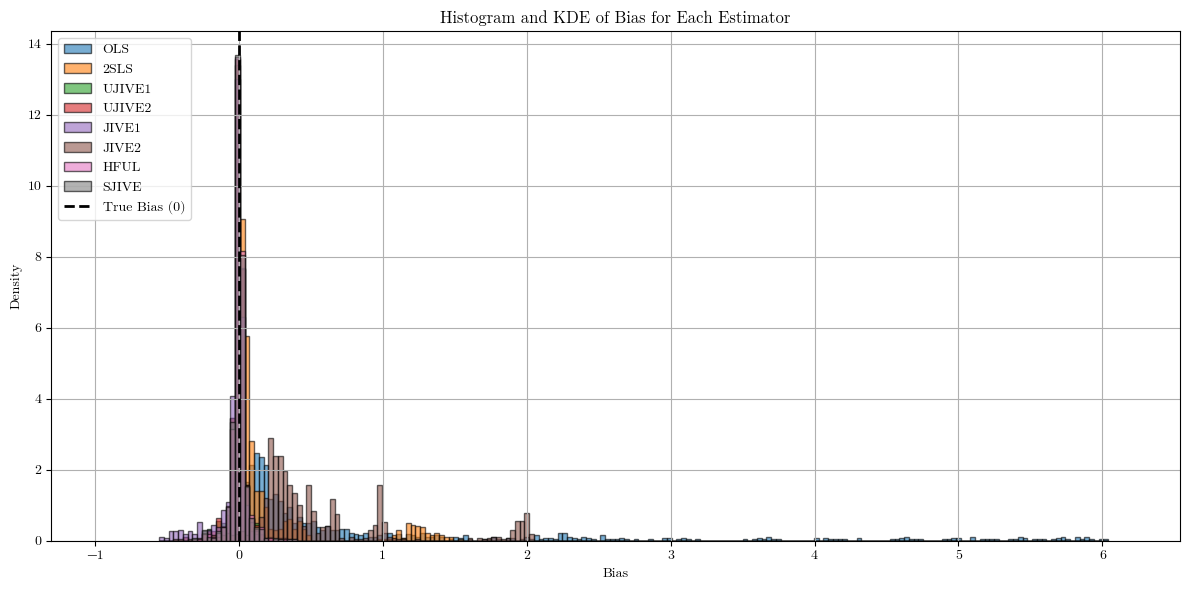

In [13]:
plt.figure(figsize=(12, 6))

# Get unique estimators and assign a unique color to each
estimators = results_df['estimator'].unique()
palette = sns.color_palette("tab10", n_colors=len(estimators))
color_map = {est: palette[i] for i, est in enumerate(estimators)}

# Calculate global bin edges so all histograms use the same bins
all_biases = results_df['bias']
bin_count = 200
bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)

for estimator in estimators:
    subset = results_df[results_df['estimator'] == estimator]
    color = color_map[estimator]
    display(subset)
    # Plot histogram (barplot) with matching color and fixed bins
    plt.hist(
        subset['bias'],
        bins=bin_edges,
        alpha=0.6,
        label=estimator,
        edgecolor='black',
        linewidth=1,
        density=True,
        color=color,
    )

plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.ylabel('Density')
plt.title('Histogram and KDE of Bias for Each Estimator')
plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
plt.legend(frameon=True, loc='upper left')
plt.grid(True)
plt.tight_layout()
#plt.savefig("../figures/bias_plot.png", dpi=900, bbox_inches='tight')
plt.show()

In [14]:
import seaborn as sns

import os
os.makedirs("figures", exist_ok=True)

grouped = results_df.groupby(['num_instruments', 'strength'])

for (num_instruments, strength), group in grouped:
    plt.figure(figsize=(12, 6))
    estimators = group['estimator'].unique()
    palette = sns.color_palette("tab10", n_colors=len(estimators))
    color_map = {est: palette[i] for i, est in enumerate(estimators)}
    all_biases = group['bias']
    bin_count = 200
    bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)
    for estimator in estimators:
        subset = group[group['estimator'] == estimator]
        color = color_map[estimator]
        # Histogram
        plt.hist(
            subset['bias'],
            bins=bin_edges,
            alpha=0.6,
            label=estimator,
            edgecolor='black',
            linewidth=1,
            density=True,
            color=color
        )
        # KDE
        sns.kdeplot(
            subset['bias'],
            label=f"{estimator} KDE",
            linewidth=2,
            color=color,
            fill=True,
        )
    plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
    plt.xlabel('Bias')
    plt.ylabel('Density')
    plt.title(f'Histogram and KDE of Bias: Instruments={num_instruments}, Strength={strength:.2f}')
    plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
    plt.legend(frameon=True, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    fname = f"figures/bias_kde_inst{num_instruments}_str{strength:.2f}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {fname}")

Saved plot to figures/bias_kde_inst100_str0.10.png
Saved plot to figures/bias_kde_inst100_str0.20.png
Saved plot to figures/bias_kde_inst100_str0.30.png
Saved plot to figures/bias_kde_inst100_str0.40.png
Saved plot to figures/bias_kde_inst100_str0.50.png
Saved plot to figures/bias_kde_inst100_str0.60.png
Saved plot to figures/bias_kde_inst100_str0.70.png
Saved plot to figures/bias_kde_inst100_str0.80.png
Saved plot to figures/bias_kde_inst100_str0.90.png
Saved plot to figures/bias_kde_inst111_str0.10.png
Saved plot to figures/bias_kde_inst111_str0.20.png
Saved plot to figures/bias_kde_inst111_str0.30.png
Saved plot to figures/bias_kde_inst111_str0.40.png
Saved plot to figures/bias_kde_inst111_str0.50.png
Saved plot to figures/bias_kde_inst111_str0.60.png
Saved plot to figures/bias_kde_inst111_str0.70.png
Saved plot to figures/bias_kde_inst111_str0.80.png
Saved plot to figures/bias_kde_inst111_str0.90.png
Saved plot to figures/bias_kde_inst125_str0.10.png
Saved plot to figures/bias_kde_

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("figures", exist_ok=True)

grouped = results_df.groupby(['num_instruments', 'strength'])

for (num_instruments, strength), group in grouped:
    plt.figure(figsize=(12, 6))
    estimators = group['estimator'].unique()
    palette = sns.color_palette("tab10", n_colors=len(estimators))
    color_map = {est: palette[i] for i, est in enumerate(estimators)}
    all_biases = group['bias']
    bin_count = 200
    bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)
    for estimator in estimators:
        subset = group[group['estimator'] == estimator]
        color = color_map[estimator]
        # Plot histogram (barplot) with matching color and fixed bins
        plt.hist(
            subset['bias'],
            bins=bin_edges,
            alpha=0.6,
            label=estimator,
            edgecolor='black',
            linewidth=1,
            density=True,
            color=color
        )
        # Plot KDE curve with the same color
        sns.kdeplot(
            subset['bias'],
            label=f"{estimator} KDE",
            linewidth=2,
            color=color,
            fill=True,
        )
    plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
    plt.xlabel('Bias')
    plt.ylabel('Density')
    plt.title(f'Histogram and KDE of Bias: Instruments={num_instruments}, Strength={strength:.2f}')
    plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
    plt.legend(frameon=True, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    fname = f"figures/bias_kde_inst{num_instruments}_str{strength:.2f}.png"
    plt.savefig(fname, dpi=900, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {fname}")

Saved plot to figures/bias_kde_inst100_str0.10.png
Saved plot to figures/bias_kde_inst100_str0.20.png
Saved plot to figures/bias_kde_inst100_str0.30.png
Saved plot to figures/bias_kde_inst100_str0.40.png
Saved plot to figures/bias_kde_inst100_str0.50.png
Saved plot to figures/bias_kde_inst100_str0.60.png
Saved plot to figures/bias_kde_inst100_str0.70.png
Saved plot to figures/bias_kde_inst100_str0.80.png
Saved plot to figures/bias_kde_inst100_str0.90.png
Saved plot to figures/bias_kde_inst111_str0.10.png
Saved plot to figures/bias_kde_inst111_str0.20.png
Saved plot to figures/bias_kde_inst111_str0.30.png
Saved plot to figures/bias_kde_inst111_str0.40.png
Saved plot to figures/bias_kde_inst111_str0.50.png
Saved plot to figures/bias_kde_inst111_str0.60.png
Saved plot to figures/bias_kde_inst111_str0.70.png
Saved plot to figures/bias_kde_inst111_str0.80.png
Saved plot to figures/bias_kde_inst111_str0.90.png
Saved plot to figures/bias_kde_inst125_str0.10.png
Saved plot to figures/bias_kde_

### Black and White version

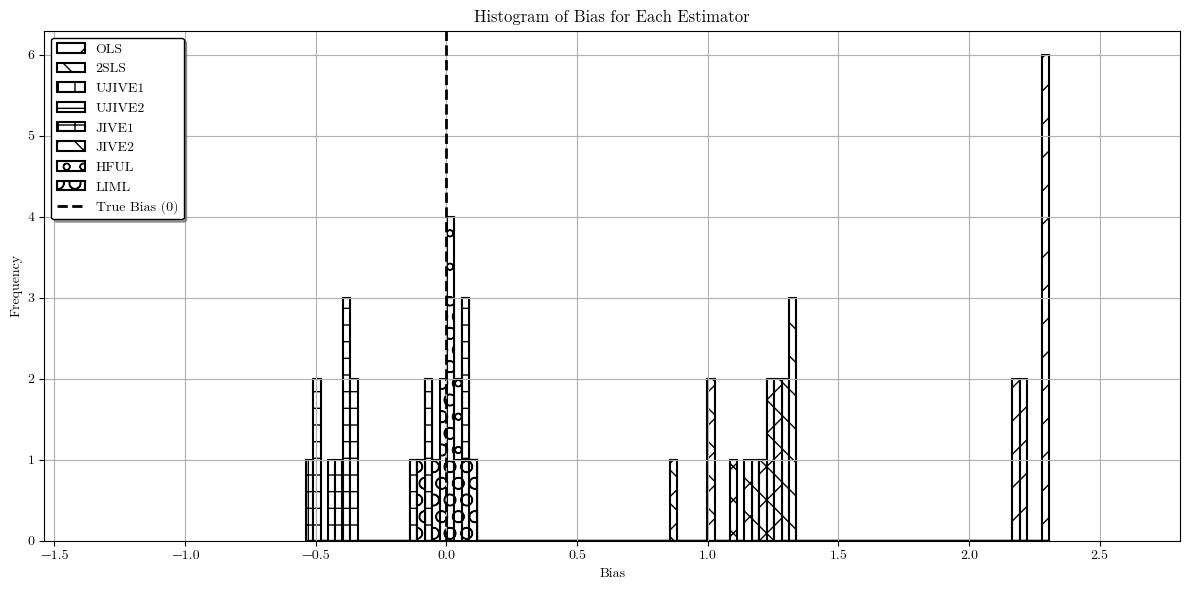

In [ ]:
import matplotlib.pyplot as plt

true_beta = 2
bin_count = 100

all_biases = results_df['bias']
bin_range = (all_biases.min(), all_biases.max())

plt.figure(figsize=(12, 6))
hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for i, estimator in enumerate(results_df['estimator'].unique()):
    subset = results_df[results_df['estimator'] == estimator]
    plt.hist(
        subset['bias'],
        bins=bin_count,
        range=bin_range,
        alpha=1.0,
        label=estimator,
        color='white',
        edgecolor='black',
        linewidth=1.5,
        hatch=hatch_patterns[i % len(hatch_patterns)]
    )

plt.axvline(0, color='black', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.xlim(all_biases.min() - 1, all_biases.max()+0.5)
plt.ylabel('Frequency')
plt.title('Histogram of Bias for Each Estimator')
plt.legend(frameon=True, loc='upper left', fancybox=True, shadow=True, edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/bias_plot_bw.png", dpi=300, bbox_inches='tight')
plt.show()

# Old DGP just in case

In [ ]:
"""#Pick a vector length:
n = 1000

#Getting our Z's and making a Z matrix:
Z = np.random.randn(n, 1)
column_of_ones = np.ones((Z.shape[0], 1))
Z = np.hstack((column_of_ones, Z))
#pprint(Z)

#Parameter vectors:
α = np.array([1,1])
β = np.array([1,2])
#pprint(α)
#pprint(β)

#Error terms:
e1 = np.random.normal(0,5,n)
e2 = np.random.normal(0,5,n)
δ = np.random.normal(0,1)
ε = 2*e1 - 2*e2 + δ

#Making our endogenous variable:
x = np.dot(Z,α) + .2*e1
X = np.column_stack((column_of_ones, x))
#pprint(X)

#Outcome vector:
Y = np.dot(X,β) + ε

#OLS benchmark:
bhat_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T, Y))

# Check to see if the Z'Z matrix is invertible
if np.linalg.matrix_rank(Z.T @ Z) == Z.shape[1]:  # Should be True
    print("Z'Z is invertible")
else:
    print("Z'Z is not invertible")

cond_number = np.linalg.cond(Z.T @ Z)
print(f"Condition number of Z.T @ Z: {cond_number}")
if cond_number > 1e10:  # Threshold for ill-conditioning
    raise ValueError("Z.T @ Z is ill-conditioned and may cause numerical instability.")


#2sls comparison:
Zt_Z = np.dot(Z.T, Z)
Zt_Z_inv = np.linalg.inv(Zt_Z)
pz = np.dot(np.dot(Z, Zt_Z_inv), Z.T)
proj_x = np.dot(pz, X)
first = np.linalg.inv(np.dot(proj_x.T, X))
second = np.dot(proj_x.T, Y)
bhat_2sls = np.dot(first, second)


ujive1 = UJIVE1(Y,X,Z,talk=False)
ujive2 = UJIVE2(Y,X,Z,talk=False)
tsls = TSLS(Y,X,Z, talk=False)

# Combine matrices into a single DataFrame
df = pd.DataFrame({
    "Y": Y,  # Outcome vector
    **{f"X{i}": X[:, i] for i in range(X.shape[1])},  # Endogenous variables
    **{f"Z{i}": Z[:, i] for i in range(Z.shape[1])}   # Instrumental variables
})

# Save the DataFrame to a CSV file
df.to_csv('data.csv', index=False)

#Compare them:
print("OLS:", bhat_ols[1])
print("2SLS:", bhat_2sls[1])"""

'#Pick a vector length:\nn = 1000\n\n#Getting our Z\'s and making a Z matrix:\nZ = np.random.randn(n, 1)\ncolumn_of_ones = np.ones((Z.shape[0], 1))\nZ = np.hstack((column_of_ones, Z))\n#pprint(Z)\n\n#Parameter vectors:\nα = np.array([1,1])\nβ = np.array([1,2])\n#pprint(α)\n#pprint(β)\n\n#Error terms:\ne1 = np.random.normal(0,5,n)\ne2 = np.random.normal(0,5,n)\nδ = np.random.normal(0,1)\nε = 2*e1 - 2*e2 + δ\n\n#Making our endogenous variable:\nx = np.dot(Z,α) + .2*e1\nX = np.column_stack((column_of_ones, x))\n#pprint(X)\n\n#Outcome vector:\nY = np.dot(X,β) + ε\n\n#OLS benchmark:\nbhat_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T, Y))\n\n# Check to see if the Z\'Z matrix is invertible\nif np.linalg.matrix_rank(Z.T @ Z) == Z.shape[1]:  # Should be True\n    print("Z\'Z is invertible")\nelse:\n    print("Z\'Z is not invertible")\n\ncond_number = np.linalg.cond(Z.T @ Z)\nprint(f"Condition number of Z.T @ Z: {cond_number}")\nif cond_number > 1e10:  # Threshold for ill-conditioning\n